# 3er entrega - Sistemas de recomendación

En esta entrega vamos a trabajar con un sistema de recomendación.

Vamos a aprovechar la competencia de Telecom que vimos ya que los datos son reales y están buenos para practicar.

En el siguiente repositorio pueden encontrar el significado de cada columna de los datasets:
https://github.com/Datathon2021/Recomendador

Consigna:

- Dividir set en train y test. Tomar como train los datos hasta el 1 de marzo de 2021. Desde el 1ro de marzo en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

Recomendaciones:
- En este caso no tenemos ratings explícitos como los casos que vimos, deben generar ustedes estos ratings mediante algún criterio. Lo más simple podría ser utilizar ratings binarios (lo vió / no lo vió).
- Hay una columna que nos indica hasta cuando va a estar disponible el contenido
- La columna **end_vod_date**: "fecha de finalización de la disponibilidad del activo en la plataforma" puede llegar a serles muy útil. ¿Tiene sentido recomendar algo que no va a estar disponible en el set de test? (a partir del 1 de marzo de 2021).
- Comiencen con algo SIMPLE. No se compliquen con todas las columnas que tiene el dataset. No van a necesitar usar todas, muchas columnas podrán descartarlas dependiendo del enfoque que tomen.

Datos:
- https://drive.google.com/file/d/1BmA1eiSJxdyRuP9AVnLov4yXsou5AQHt/view?usp=sharing

- https://drive.google.com/file/d/1BmA1eiSJxdyRuP9AVnLov4yXsou5AQHt/view?usp=sharing

Fecha de entrega: **4 de Septiembre de 2022**.

Enviar notebook a darb302@gmail.com. 



In [2]:
#Importamos las librerias necesarias para abrir el dataset
import pandas as pd
import numpy as np

#Importamos el dataset de metadata
df_meta = pd.read_csv('https://raw.githubusercontent.com/Blassaj/Icaro_Data-Science/main/Sprint_3/metadata.csv', sep= ';', parse_dates= ['create_date', 'modify_date', 'start_vod_date', 'end_vod_date'], dayfirst = False)
df_meta.head(2)

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01 10:18:15+00:00,2019-01-26 06:37:18+00:00,2017-12-01 00:00:00+00:00,2020-12-01 23:59:59+00:00
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19 20:58:15+00:00,2019-09-17 19:02:03+00:00,2017-12-15 00:00:00+00:00,2022-12-14 23:59:59+00:00



**Metadata**

Contiene la metadata asociada a cada uno de los contenidos. Las variables incluidas son:

* asset_id: código de identificación de cada activo (video) disponible en Flow.
* content_id: código de identificación que agrupa los distintos asset_id asociados a un mismo contenido (por ejemplo, cada episodio de una misma serie tiene su propio asset_id, mientras que la serie se identifica con un content_id único).
* title: título
* reduced_title: título reducido
* episode_title: título del episodio (válido para contenidos episódicos, como las series).
* show_type: tipo de show - las categorías son autorreferenciales con excepción de “Rolling”, que indica que se trata de una serie incompleta, y “Web”, la cual remite a contenidos pensados íntegramente en formato digital (series web).
* released_year: año de lanzamiento.
* country_of_origin: país de origen – expresado con el código de dos letras propio del estándar internacional de normalización ISO 3166 -
* category: categoría o género al que pertenece el contenido - puede haber una o más.
* keywords: palabras clave o tags asociadas al contenido - puede haber una o más.
* description: descripción (sinopsis).
* reduced_desc: descripción (sinopsis) reducida.
* cast_first_name: nombre y apellido de los actores y actrices principales.
* credits_first_name: nombre y apellido del director o directora.
* run_time_min: duración total, expresada en minutos.
* audience: audiencia target.
* made_for_tv: variable dummy que indica si el contenido fue hecho para TV.
* close_caption: variable dummy que indica si el contenido posee subtítulos.
* sex_rating: variable dummy que indica si el contenido tiene escenas de sexo explícitas.
* violence_rating: variable dummy que indica si el contenido tiene escenas de violencia explícitas.
* language_rating: variable dummy que indica si el contenido posee lenguaje que puede ser considerado ofensivo o inapropiado.
* dialog_rating: variable dummy que indica si el contenido posee diálogos que pueden ser considerado ofensivos o inapropiados.
* fv_rating: variable dummy que indica si el contenido tiene rating de FV, que corresponde a público infantil con violencia ficticia.
* pay_per_view: variable dummy que indica si se trata de un alquiler.
* pack_premium_1: variable dummy que indica si se trata de un contenido exclusivo del pack premium 1.
* pack_premium_2: variable dummy que indica si se trata de un contenido exclusivo del pack premium 2.
* create_date: fecha de creación del activo.
* modify_date: fecha de modificación del activo.
* start_vod_date: fecha desde la cual el activo se encuentra disponible en la plataforma.
* end_vod_date: fecha de finalización de la disponibilidad del activo en la plataforma.

In [3]:
#Modificamos los atributos datetime eliminado la hora (pierde el formato datetime y quedan como str)
def remove_hour(dataf, lista):
  for i in range(len(lista)):
    dataf[lista[i]] = dataf[lista[i]].apply(lambda x: x.strftime('%Y-%m-%d'))
    dataf[lista[i]] = pd.to_datetime(dataf[lista[i]], format= '%Y-%m-%d')

  return dataf

dates = ['create_date', 'modify_date', 'start_vod_date', 'end_vod_date']
df_meta = remove_hour(df_meta, dates)

df_meta.sample(3)

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
13316,7823,2001.0,Ep:12 El Puntero,El_Puntero_E12,Episodio 12,Serie,2012.0,AR,Drama/Político,"Políticos,Droga,Narcos,Pobreza,Latinoamérica,C...",...,N,N,N,N,N,N,2016-11-22,2020-04-05,2016-09-01,2030-04-30
32958,13410,1040.0,T:1 Ep:20 El Increíble Mundo de Gumball,El_Increible_T1_E20,El genio,TV,2011.0,US,Infantil/Dibujos Animados,"Ingenioso,Familia,Hermanos,Mascotas",...,N,N,N,N,N,N,2021-03-29,2021-03-29,2021-03-11,2021-04-18
16408,11604,2123.0,T:2 Ep:11 Animal Manía,Animal_Mania_T2_E11,Episodio 11,TV,2018.0,US,Infantil,"Aventuras,Mascotas,Amistad",...,N,N,N,N,N,N,2018-12-04,2018-12-04,2018-11-28,2023-06-30


Cuando vemos un valor NaN en el atributo "episode_title" es porque se trata de una película.

In [4]:
#Importamos el dataset de train
from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv('/content/drive/MyDrive/Doctorado/ICARO - Data Science/Practicos/Sprint 3/train.csv', parse_dates= ['tunein', 'tuneout'], dayfirst = False)
df_train.head()

Mounted at /content/drive


,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0
2,1,3387,STB,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0
3,1,3387,STB,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0



**Train**

Este dataset contiene los registros de visualizaciones de contenidos de Flow del formato video on demand (VOD), correspondiente a una muestra aleatoria de más de 113 mil perfiles. A continuación, se detalla el diccionario de variables de esta tabla:

* customer_id: código de identificación de cada cliente de Flow (puede tener asociados uno o más account_id).
* account_id: código de identificación de cada perfil de Flow (se corresponde con un único customer_id).
* device_type: indica el tipo de dispositivo desde el que se efectuó la visualización. Las categorías posibles son:
  * CLOUD: cliente web.
  * PHONE: teléfono celular.
  * STATIONARY: smart TV.
  * STB: set-top box, el decodificador Flow.
  * TABLET
* asset_id: código de identificación de cada activo (video) disponible en la plataforma.
* tunein: fecha y hora de inicio de cada visualización.
* tuneout: fecha y hora de finalización de cada visualización.
* resume: variable dummy que indica si se reanuda un consumo anterior del mismo asset_id.



## Análisis de los atributos presentes

### Dataset Metadata

In [5]:
#Tamaño del dataset de metadata
df_meta.shape

(33144, 30)

In [6]:
#Atributos presentes en el dataset
df_meta.columns

Index(['asset_id', 'content_id', 'title', 'reduced_title', 'episode_title',
       'show_type', 'released_year', 'country_of_origin', 'category',
       'keywords', 'description', 'reduced_desc', 'cast_first_name',
       'credits_first_name', 'run_time_min', 'audience', 'made_for_tv',
       'close_caption', 'sex_rating', 'violence_rating', 'language_rating',
       'dialog_rating', 'fv_rating', 'pay_per_view', 'pack_premium_1',
       'pack_premium_2', 'create_date', 'modify_date', 'start_vod_date',
       'end_vod_date'],
      dtype='object')

In [7]:
#Tipos de datos de cada atributo
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33144 entries, 0 to 33143
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   asset_id            33144 non-null  int64         
 1   content_id          33123 non-null  float64       
 2   title               33144 non-null  object        
 3   reduced_title       33144 non-null  object        
 4   episode_title       28997 non-null  object        
 5   show_type           33140 non-null  object        
 6   released_year       33144 non-null  float64       
 7   country_of_origin   33140 non-null  object        
 8   category            33144 non-null  object        
 9   keywords            33142 non-null  object        
 10  description         33142 non-null  object        
 11  reduced_desc        33144 non-null  object        
 12  cast_first_name     24412 non-null  object        
 13  credits_first_name  20590 non-null  object    

In [8]:
#Chequeamos la presencia de valores NaN
df_meta.isna().sum()

asset_id                  0
content_id               21
title                     0
reduced_title             0
episode_title          4147
show_type                 4
released_year             0
country_of_origin         4
category                  0
keywords                  2
description               2
reduced_desc              0
cast_first_name        8732
credits_first_name    12554
run_time_min              0
audience                  1
made_for_tv               0
close_caption             0
sex_rating                0
violence_rating           0
language_rating           0
dialog_rating             0
fv_rating                 0
pay_per_view              0
pack_premium_1            0
pack_premium_2            0
create_date               0
modify_date               0
start_vod_date            0
end_vod_date              0
dtype: int64

In [9]:
#Visualizamos la estadística descriptiva de los atributos numéricos
df_meta.describe()

,asset_id,content_id,released_year,run_time_min
count,33144.000000,33123.000000,33144.000000,33144.000000
mean,16571.500000,1371.500891,2016.003922,48.060916
std,9567.992997,1153.024487,6.026482,35.214128
min,0.000000,0.000000,1942.000000,0.000000
25%,8285.750000,387.000000,2015.000000,22.000000
50%,16571.500000,1019.000000,2018.000000,43.000000
75%,24857.250000,2160.000000,2019.000000,67.000000
max,33143.000000,4371.000000,2021.000000,308.000000


*   Año de lanzamiento: Como curiosidad vemos que el título más antiguo se estrenó en 1942, aunque la mayoría de los títulos son modernos (2015 en adelante).
*   Duración (minutos): Vemos que la mayoría de los títulos duran cerca de 1 hora o menos, por lo que podemos inferir hay una gran influencia de series o contenido genérico de televisión.



### Dataset Train

In [10]:
#Tamaño del dataset de train
df_train.shape

(3657801, 7)

In [11]:
#Atributos presentes en el dataset
df_train.columns

Index(['customer_id', 'account_id', 'device_type', 'asset_id', 'tunein',
       'tuneout', 'resume'],
      dtype='object')

In [12]:
#Tipos de datos de cada atributo
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657801 entries, 0 to 3657800
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   customer_id  int64         
 1   account_id   int64         
 2   device_type  object        
 3   asset_id     float64       
 4   tunein       datetime64[ns]
 5   tuneout      datetime64[ns]
 6   resume       int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 195.3+ MB


##### Creamos un atributo con la duración de la visualización

In [22]:
#Hacemos la diferencia de los atributos y lo pasamos a tipo floar con la funcion timedelta seleccionando los minutos
df_train['vis_time'] = (df_train['tuneout'] - df_train['tunein']) / np.timedelta64(1, 'm') 

df_train['vis_time'].head()

0    43.0
1    44.0
2    18.0
3    55.0
4    20.0
Name: vis_time, dtype: float64

In [23]:
#Removemos la hora, minutos y segundos de los atributos 'tunein' y 'tuneout'
dates2 = ['tunein', 'tuneout']
df_train = remove_hour(df_train, dates2)

In [24]:
#Chequeamos la presencia de valores NaN
df_train.isna().sum()

customer_id     0
account_id      0
device_type    29
asset_id       22
tunein          0
tuneout         0
resume          0
vis_time        0
dtype: int64

In [25]:
#Visualizamos la estadística descriptiva de los atributos numéricos
df_train.describe()

,customer_id,account_id,asset_id,resume,vis_time
count,3.657801e+06,3.657801e+06,3.657779e+06,3.657801e+06,3.657801e+06
mean,5.697459e+04,5.902651e+04,1.667222e+04,4.005672e-01,2.697473e+01
std,3.090677e+04,3.237536e+04,9.666494e+03,4.900134e-01,2.938743e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
25%,3.168700e+04,3.142200e+04,8.318000e+03,0.000000e+00,7.000000e+00
50%,5.759500e+04,6.078200e+04,1.641900e+04,0.000000e+00,1.700000e+01
75%,8.250200e+04,8.752400e+04,2.512800e+04,1.000000e+00,3.900000e+01
max,1.123390e+05,1.138800e+05,3.314300e+04,1.000000e+00,2.400000e+02


## Drop de atributos innecesarios

### Dataset Metadata

In [26]:
df_meta = df_meta.drop(['episode_title','description','reduced_desc','cast_first_name','credits_first_name','create_date','modify_date'], axis= 1)
df_meta.shape

(33144, 23)

Removemos los atributos:
* "episode_title", "cast_first_name" y "credits_first_name" por el alto número de nulos.
* "create_date" y "modify_date" para no generar confusión con "start y end vod".
* "description" y "reduced_desc", que son la sinopsis, porque tenemos un atributo "keywords" y "audience" para utilizar en el recomendador.

### Dataset train

In [27]:
df_train = df_train.drop(['customer_id'], axis= 1)
df_train.shape

(3657801, 7)

Dropeamos "customer_id" ya que las recomendaciones se van a hacer sobre cuentas únicas ("account_id").

## Removemos los valores NaN

In [28]:
#Removemos los registros con contenido nulo
df_meta = df_meta.dropna()
df_meta.shape

(33112, 23)

In [29]:
#Removemos los registros con contenido nulo
df_train = df_train.dropna()
df_train.shape

(3657750, 7)

## Unimos los datasets de train y meta

In [30]:
#Unimos el dataset de train (contiene los usuarios) con el de metadata (contiene los titulos)
df = pd.merge(df_train, df_meta)
df.shape

(3657070, 29)

In [31]:
df.columns

Index(['account_id', 'device_type', 'asset_id', 'tunein', 'tuneout', 'resume',
       'vis_time', 'content_id', 'title', 'reduced_title', 'show_type',
       'released_year', 'country_of_origin', 'category', 'keywords',
       'run_time_min', 'audience', 'made_for_tv', 'close_caption',
       'sex_rating', 'violence_rating', 'language_rating', 'dialog_rating',
       'fv_rating', 'pay_per_view', 'pack_premium_1', 'pack_premium_2',
       'start_vod_date', 'end_vod_date'],
      dtype='object')

## Análisis Exploratorio de Datos (EDA)

In [32]:
#Importamos las librerias necesarias para visualización
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Cantidad de cuentas

In [33]:
#Cantidad de cuentas totales en el dataset
cuentas = df_train['account_id'].nunique()
print(f'La cantidad de cuentas totales en el dataset es: {cuentas}')

La cantidad de cuentas totales en el dataset es: 113878


#### Tiempo de visualización

In [44]:
#Tiempo promedio de visualización por tipo de dispositivo
tiempo_vis = df.groupby('device_type', as_index= False).agg({'vis_time':'mean'})
tiempo_vis

,device_type,vis_time
0,CLOUD_CLIENT,45.216748
1,PHONE,26.803112
2,STATIONARY,34.867840
3,STB,25.264079
4,TABLET,31.240275


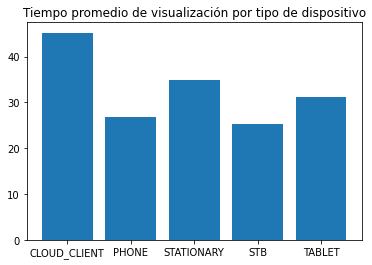

In [52]:
#Barplot con el promedio de visualizacion por dispositivo
plt.figure()
plt.title('Tiempo promedio de visualización por tipo de dispositivo')
plt.bar(x= tiempo_vis['device_type'], height= tiempo_vis['vis_time'])
plt.show()

#### Cantidad de títulos

In [53]:
#Cantidad de títulos diferentes presentes en el dataset
df_meta['content_id'].nunique()

4361

In [54]:
#Cantidad de títulos vistos por cada cuenta
titulo_por_cuenta = df.groupby('account_id').agg({'asset_id':'nunique'})

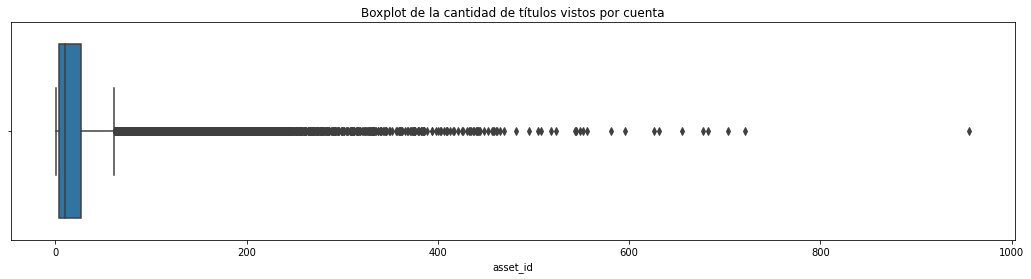

In [55]:
#Boxplot de títulos vistos por cada cuenta
plt.figure(figsize=(18,4))
plt.title("Boxplot de la cantidad de títulos vistos por cuenta")
sns.boxplot(x= titulo_por_cuenta['asset_id'])
plt.show()

In [56]:
#Cantidad minima de títulos vistos por una cuenta en el dataset
titulo_por_cuenta['asset_id'].min()

1

In [57]:
#Cantidad media de títulos vistos por una cuenta en el dataset
round(titulo_por_cuenta['asset_id'].mean(), 2)

22.74

In [58]:
#Cantidad máxima de títulos vistos por una cuenta en el dataset
titulo_por_cuenta['asset_id'].max()   #Raro, tiene que haber visto 10 títulos por día...

956

In [59]:
#El título más antiguo de flow es del 2 de agosto del 2001
df_meta['start_vod_date'].min()

Timestamp('2001-08-02 00:00:00')

In [60]:
#El título más nuevo de flow es del 21 de octubre del 2021
df_meta['start_vod_date'].max()

Timestamp('2021-10-21 00:00:00')

### Dispositivos

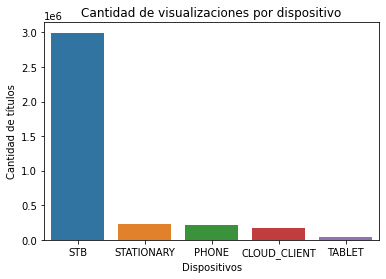

In [61]:
#Gráfico de cantidad de visualizaciones por dispositivo
plt.figure()
plt.title("Cantidad de visualizaciones por dispositivo")
sns.countplot(x= 'device_type', data= df, order= df['device_type'].value_counts().index)
plt.xlabel('Dispositivos')
plt.ylabel('Cantidad de títulos')
plt.show()

In [62]:
#Cantidad de visualizaciones por dispositivo
df['device_type'].value_counts()

STB             2992945
STATIONARY       224659
PHONE            216453
CLOUD_CLIENT     174502
TABLET            48511
Name: device_type, dtype: int64

In [63]:
#La primera visualización de un cliente fue:
df['tunein'].min()

Timestamp('2021-01-01 00:00:00')

In [64]:
#La última visualización de un cliente fue:
df['tunein'].max()

Timestamp('2021-03-31 00:00:00')

### Títulos

In [65]:
df['show_type'].value_counts()

Serie           1550000
TV              1178083
Película         867076
Web               32706
Rolling           26273
Gaming             2878
Series,Serie         54
Name: show_type, dtype: int64

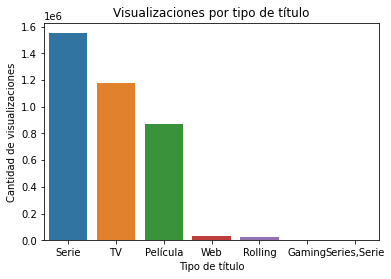

In [66]:
#Gráfico de cantidad de visualizaciones por tipo de título
plt.figure()
plt.title("Visualizaciones por tipo de título")
sns.countplot(x= 'show_type', data= df, order= df['show_type'].value_counts().index)
plt.xlabel('Tipo de título')
plt.ylabel('Cantidad de visualizaciones')
plt.show()

### Audiencias

In [67]:
#Visualizaciones por tipo de audiencia
df['audience'].value_counts()

General       1545878
Mujeres        608666
Preescolar     461757
Teens          357202
Niños          256245
Juvenil        176632
Familiar       126687
Hombres        121359
NIños            2636
Gaming              8
Name: audience, dtype: int64

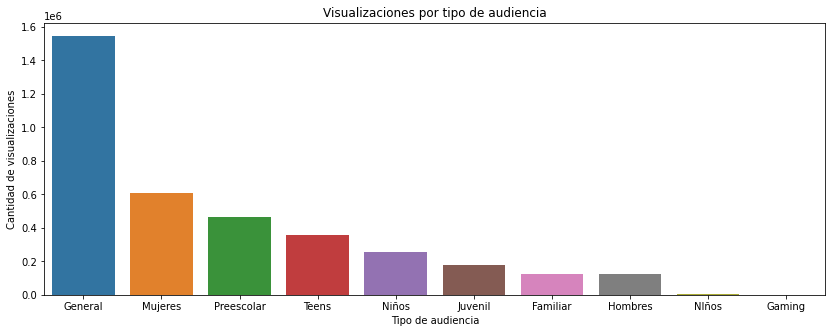

In [68]:
#Gráfico de cantidad de visualizaciones por tipo de audiencia
plt.figure(figsize= (14,5))
plt.title("Visualizaciones por tipo de audiencia")
sns.countplot(x= 'audience', data= df, order= df['audience'].value_counts().index)
plt.xlabel('Tipo de audiencia')
plt.ylabel('Cantidad de visualizaciones')
plt.show()

### Categorías

In [69]:
#Cantidad de categorías distintas
df_meta['category'].nunique()

219

In [70]:
#Generamos un dataset agrupando y contando las distintas categorias
categorias = df['category'].value_counts().reset_index()
categorias.columns = ['categorias', 'popularidad']

#### Top 5 categorías

In [71]:
categorias.head(5)

,categorias,popularidad
0,Infantil/Dibujos Animados,791800
1,Drama,353800
2,Drama/Romance,296433
3,Drama/Comedia,211032
4,Drama/Crimen,208369


#### Last 5 categorías

In [72]:
categorias.tail(5)

,categorias,popularidad
206,Romance/Biografía,3
207,Suspenso/Acción,3
208,Romance/Aventura,3
209,Musical/Drama,1
210,Fantasía/Acción,1


### Keywords

In [73]:
#Separamos las keywords del dataset meta
keywords = df[['keywords']].copy()
keywords['keywords'] = keywords['keywords'].str.split(',')

In [74]:
#Con la función explode() de pandas separamos cada keyword en un registro nuevo
keywords = keywords.explode('keywords')
keywords.shape

(15205090, 1)

In [75]:
#Contabilizamos y ordenamos los keywords presentes
popular_key = pd.DataFrame(keywords[['keywords']].value_counts()).reset_index(drop=False)
popular_key.columns = ['keyword','popularidad']

#### Top 5 keywords

In [76]:
popular_key.head(5)

,keyword,popularidad
0,Familia,762789
1,Crimen,629975
2,Amigos,541686
3,Europa,491063
4,Aventuras,395789


#### Last 5 keywords

In [77]:
popular_key.tail(5)

,keyword,popularidad
333,Rob,15
334,Halloween,10
335,Las Vegas,6
336,Bizarras,3
337,Novias,1


## Drop de atributos por consigna

In [78]:
#Dropeamos este atributo porque la recomendación se hara sobre el "content_id"
df = df.drop('asset_id', axis= 1)

In [79]:
#Eliminamos los registros de aquellos títulos que no van a estar disponibles a partir del 1 de marzo
df = df[df['end_vod_date'] > '2021-03-01'].copy()

In [80]:
df.shape

(3354246, 28)

Eliminamos del dataset aproximadamente 300.000 registros que representan títulos que no van a estar disponibles en la plataforma Flow a partir del 1 de marzo.

## Creamos el atributo binario "visto" para usar en el recomendador

In [82]:
#Creamos el atributo visto y le asignamos el valor 1 si el usuario muestra un tiempo de visualización mayor a 20 minutos
df['visto'] = 0
df.loc[df['vis_time'] > 20, 'visto'] = 1

df[['vis_time','visto']].sample(10)

,vis_time,visto
318900,79.0,1
2732779,47.0,1
2536081,29.0,1
2522860,45.0,1
1594269,9.0,0
2077740,12.0,0
3158065,23.0,1
962766,51.0,1
2509319,10.0,0
98368,18.0,0


## Creacion dataset de train y test

In [83]:
#Separamos el nuevo dataset en 2 para tener uno de train y otro de test (punto: 1 de marzo)
from datetime import datetime

train = df[df['tunein'] < '2021-03-01']
test = df[df['tunein'] >= '2021-03-01']

row1, col1 = train.shape
row2, col2 = test.shape

print(f'La cantidad de registros presentes en el dataset de entrenamiento es: {row1}')
print(f'La cantidad de registros presentes en el dataset de testeo es: {row2}')

La cantidad de registros presentes en el dataset de entrenamiento es: 2036651
La cantidad de registros presentes en el dataset de testeo es: 1317595


## Generamos la matriz de interacciones

In [84]:
inter_matrix = pd.pivot_table(train, index= 'account_id', columns= 'content_id', values='visto')
inter_matrix.shape

(97504, 3014)

In [86]:
inter_matrix = inter_matrix.fillna(0)
inter_matrix.sample(5)

content_id,0.0,1.0,3.0,6.0,7.0,8.0,9.0,11.0,12.0,13.0,...,4357.0,4358.0,4359.0,4360.0,4361.0,4362.0,4363.0,4364.0,4365.0,4366.0
account_id,,,,,,,,,,,,,,,,,,,,,
45228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Armamos los diccionarios de usuarios y títulos 

In [96]:
#Diccionario de usuarios que después se usa para hacer las predicciones
account_ids = list(inter_matrix.index)
account_dict = {}
counter = 0 
for i in account_ids:
    account_dict[i] = counter
    counter += 1

In [97]:
#Diccionario de títulos que después se usa para hacer las predicciones
item_id = list(inter_matrix.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

In [88]:
#Armamos la Compressed Sparse Row matrix
from scipy.sparse import csr_matrix
account_content_inter = csr_matrix(inter_matrix.values)

## Modelo

In [90]:
#Instalamos la librería del recomendador
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 29.1 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705374 sha256=fbdd97f74df2c46fe2cf5ea05b5ef0efcc8885a4b6f2f2c2020816bfea9fc48e
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [91]:
#Importamos la librería previamente instalada y entrenamos nuestro modelo
from lightfm import LightFM

modelo = LightFM(loss= 'warp', random_state= 0, learning_rate= 0.03, no_components=100)
modelo.fit(account_content_inter, epochs= 10)

In [92]:
#Definimos una función para un recomendador individual
def recomm(model, customers, user_id, user_dict, item_dict, nrec_items = 10, show = True):

    n_users, n_items = customers.shape
    user_x = user_dict[user_id]

    scores = pd.Series(model.predict(user_x, np.arange(n_items)))
    scores.index = customers.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(customers.loc[user_id,:] \
                                [customers.loc[user_id,:] > 0].index).sort_values(ascending=False))
    
    #Filtro de items que ya leyó el usuario
    scores = [x for x in scores if x not in known_items]
    recomms = scores[0:nrec_items]

    print(recomms)

    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + str(i))
            counter+=1

        print("\n Recommended Items:")
        
        counter = 1
        for i in recomms:
            print(str(counter) + '- ' + str(i))
            counter+=1
    return recomms

In [100]:
#Hacemos una prueba del recomendador con el usuario_id número 10
prueba = recomm(modelo, inter_matrix ,20 , account_dict, item_dict, show=True)  #Con el show= True nos muestra el return

[2040.0, 3900.0, 3716.0, 6.0, 1140.0, 173.0, 116.0, 1971.0, 3438.0, 2942.0]
User: 20
Known Likes:
1- 2383.0
2- 2160.0
3- 1495.0

 Recommended Items:
1- 2040.0
2- 3900.0
3- 3716.0
4- 6.0
5- 1140.0
6- 173.0
7- 116.0
8- 1971.0
9- 3438.0
10- 2942.0


In [119]:
df_meta.loc[df_meta['asset_id'].isin(prueba), ['title']]

,title
927,T:2 Ep:28 Grandes Héroes: La serie
1959,T:1 Ep:04 Las Estrellas
3013,T:1 Ep:41 Seguimos Educando Ciclo Básico Secun...
6463,12/02 - Líbero
9570,T:1 Ep:10 Pickle y Mani
12383,T:2 Ep:58 Puppy Dog Pals
18669,T:1 Ep:03 El Hipnotizador
21766,T:1 Ep:11 Ransom
24149,10/30 - Cucinare
26326,T:2 Ep:05 Manijomio


## Popularidad
Determinamos los títulos más populares como recomendación para los usuarios "coldstart" (sin registro previo de visualizaciones).

In [108]:
popular = train[['account_id','content_id']].groupby(['content_id'], as_index= False).agg({'account_id':'nunique'})
popular.columns = ['content_id','n_accounts']
popular = popular.sort_values(by= 'n_accounts', ascending= False)
popular.head(10)

,content_id,n_accounts
1059,2040.0,11481
2802,3806.0,8762
2896,3900.0,7960
2598,3598.0,3772
1176,2160.0,3505
2385,3381.0,3490
2687,3690.0,3287
2214,3210.0,3188
2550,3550.0,3026
2388,3384.0,3014


Probe incluir el atributo 'title' para ver a que título corresponden las recomendaciones pero el resultado final no era del todo satisfactorio ya que repetía series populares en los primeros puestos (a través de la recomendación de distintos capítulos).

## Recomendaciones

In [109]:
%%time
titulos_vistos_por_cuenta = {}

titulos_vistos = train[['account_id','content_id','visto']].groupby('account_id').agg({'content_id': 'unique'})

for account in titulos_vistos.index:
    watched = titulos_vistos.loc[account, 'content_id']
    titulos_vistos_por_cuenta[account] = watched

CPU times: user 8.79 s, sys: 350 ms, total: 9.14 s
Wall time: 8.76 s


In [110]:
#Generamos las recomendaciones para cada usuario del set de test
%%time
from tqdm import tqdm

#En este diccionario almacena las recomendaciones
recomendacion = {
    'account_id': [],
    'recomms': []
}

#Cantidad de cuentas y títulos
n_cuentas, n_titulos = inter_matrix.shape
titulos_ids = np.arange(n_titulos)

#Generamos la recomendación para cada usuario del dataset de test
for account in tqdm(test['account_id'].unique()):
    if account in list(inter_matrix.index):
        acc_x = account_dict[account]

        prediccion = modelo.predict(user_ids= acc_x, item_ids = titulos_ids) #Generamos la prediccion sobre el modelo previamente entrenado

        scores = pd.Series(prediccion)
        scores.index = inter_matrix.columns
        scores = list(pd.Series(scores.sort_values(ascending=False).index))#[:2000] #Tomo las primeras 2000 para que sea más rapido

        titulos_vistos = titulos_vistos_por_cuenta[account]
        scores = [x for x in scores if x not in titulos_vistos]
        scores = scores[:20]  #Recomendamos 20 titulos

        recomendacion['account_id'].append(account)
        recomendacion['recomms'].append(scores)
    else:                                             #Si es un usuario nuevo recomendamos los 20 titulos mas populares
        recomendacion['account_id'].append(account)
        recomendacion['recomms'].append(popular.sort_values(by= 'n_accounts', ascending=False).content_id.unique()[:20]) #Recomendamos 20 titulos

100%|██████████| 87606/87606 [45:39<00:00, 31.98it/s]

CPU times: user 43min 19s, sys: 2min 10s, total: 45min 29s
Wall time: 45min 39s


In [111]:
#Transformamos el diccionario en un Dataframe
recomendacion = pd.DataFrame(recomendacion)
recomendacion = recomendacion.sort_values(by='account_id', ascending=True)

In [112]:
#Visualizamos los primeros resultados de nuestro recomendador sobre el dataset de test
recomendacion.head()

,account_id,recomms
64220,2,"[2040.0, 2012.0, 2160.0, 3900.0, 2972.0, 3806...."
9909,3,"[1008.0, 3711.0, 3210.0, 3344.0, 3035.0, 518.0..."
31334,4,"[2809.0, 2822.0, 3806.0, 2827.0, 3598.0, 4366...."
56015,5,"[3806.0, 2827.0, 3035.0, 3900.0, 2040.0, 3382...."
13759,6,"[116.0, 2040.0, 3716.0, 3578.0, 1140.0, 1464.0..."


## Evaluación con MAP

In [137]:
#Resultados reales sobre los que vamos a comparar los predichos
actual_views = test[test['visto'] == 1][['account_id', 'content_id']]\
                .groupby(by='account_id', as_index=False)\
                .agg({'content_id': 'unique'})\
                .sort_values(by='account_id')

In [138]:
actual_views

,account_id,content_id
0,2,[433.0]
1,3,"[3487.0, 4111.0, 4199.0, 2340.0, 461.0, 280.0,..."
2,4,"[2212.0, 513.0, 4340.0, 565.0, 4129.0]"
3,6,"[3386.0, 3388.0, 4065.0, 3211.0, 2900.0]"
4,10,[2091.0]
...,...,...
73151,113873,[2353.0]
73152,113874,[2177.0]
73153,113875,[2012.0]
73154,113877,[2091.0]


In [139]:
prediccion = recomendacion['recomms'].values
labels = actual_views['content_id'].values

In [140]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in zip(prediccion, labels):
    n = len(pred) 
    arange = np.arange(n, dtype= np.int32) + 1.         # indexamos en base 1
    rel_k = np.in1d(pred[:n], label)                    # lista de booleanos que indican la relevancia de cada ítem
    tp = np.ones(rel_k.sum(), dtype= np.int32).cumsum() # lista con el contador de verdaderos positivos
    denom = arange[rel_k]                               # posiciones donde se encuentran los ítems relantes
    ap = (tp / denom).sum() / len(label)                # average precision
    aps.append(ap)

In [141]:
#Cálculamos el MAP para nuestro recomendador de Flow
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 3)}')

mean average precision = 0.039
